In [ ]:
# analyzing SBC amyloid, microglia after RLP treatment (blind)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import wesanderson
import os
import re
import warnings

# Suppress all warnings
warnings.filterwarnings('ignore')

In [84]:
def get_tiny_df(file_path, cols, batch, iid_channel):
    """
    Returns a df with one row, corresponding to the amyloid/microglia/astrocyte
    data for a single image.
    """
    
    df = pd.read_csv(file_path, header=2, index_col=0)
    idx = re.search(r'\d+_?[MF]_?sliceC(\d+)', file_path).group(0)
    gender = 'M' if '_M_' in idx else 'F'

    if iid_channel is None:
        # just get the volume and area
        vol = df.loc['Volume']['Sum']
        area = df.loc['Area']['Sum']
        vals = [idx, gender, batch, vol, area]
        
    else:
        # get surface, iid data
        num_cells = df.loc['Number of Disconnected Components']['Count']
        vol = df.loc['Volume']['Sum']
        sa = df.loc['Area']['Sum']
    
        df = df[df['Channel'] == iid_channel]
        mean_iid = df.loc['Intensity Sum']['Mean']
        sum_iid = df.loc['Intensity Sum']['Sum']

        vals = [idx, gender, batch, num_cells, vol, sa, sum_iid]

    return pd.DataFrame([vals], columns=cols)


def get_big_df(direc, cols, batch, iid_channel=None):
    """
    Returns a df with the amyloid/microglia/astrocyte data for all images in
    a directory.
    """
    
    files = [os.path.join(direc, f) for f in os.listdir(direc)]
    dfs = [get_tiny_df(file_path, cols, batch, iid_channel) for file_path in files]
    
    return pd.concat(dfs, ignore_index=True)


def join_dfs(dfs, sofar=None):
    """
    Inner joins a list of dfs on 'ID' and 'Gender'.
    """

    if sofar is None:
        sofar = dfs[0]
        dfs = dfs[1:]

    if len(dfs) == 0:
        return sofar

    else:
        merged_df = pd.merge(sofar, dfs[0], on=['ID', 'Gender', 'Batch'], how='inner')
        return join_dfs(dfs[1:], merged_df)


def process_replicates(df):
    """
    Averages rows w/ technical replicates (same sample number, diff. slice).
    """

    def extract_base_id(id_str):
        match = re.match(r'(\d+_[MF])_', id_str)
        return match.group(1) if match else None

    df['Base_ID'] = df['ID'].apply(extract_base_id)

    non_numeric_cols = {'ID', 'Gender', 'Batch', 'Base_ID'}
    numeric_cols = [col for col in df.columns if col not in non_numeric_cols]

    # average together tech reps, numeric
    averaged = df.groupby('Base_ID')[numeric_cols].mean().reset_index()
    averaged['ID'] = averaged['Base_ID'] + '_AVG'

    # copy over non-numeric data
    meta_cols = ['Gender', 'Batch']
    meta_info = df.groupby('Base_ID')[meta_cols].first().reset_index()

    # merge and return
    averaged = averaged.merge(meta_info, on='Base_ID')
    final_cols = ['ID', 'Gender', 'Batch'] + numeric_cols
    return averaged[final_cols]

In [61]:
# all amyloid data

sbc_amyloid_dir = '../data/SBC data/sbc amyloid '
a_cols = ['ID', 'Gender', 'Batch', 'Amyloid Plaque Count', 'Amyloid Surface Volume', 'Amyloid Surface Area', 'Total Amyloid IID']
amyloid_batches = {'1-16': 7, '18-32': 7}

a_dfs = [get_big_df(sbc_amyloid_dir + batch, a_cols, batch, 7) for batch, channel in amyloid_batches.items()]
a_df = pd.concat(a_dfs, ignore_index=True)

In [59]:
# all microglia data

sbc_microglia_dir = '../data/SBC data/sbc microglia '
m_cols = ['ID', 'Gender', 'Batch', 'Microglia Count', 'Microglia Surface Volume', 'Microglia Surface Area', 'Total Microglia IID']
microglia_batches = {'1-16': 6, '18-32': 6}

m_dfs = [get_big_df(sbc_microglia_dir + batch, m_cols, batch, channel) for batch, channel in microglia_batches.items()]
m_df = pd.concat(m_dfs, ignore_index=True)

In [60]:
# all volume data

sbc_vol_dir = '../data/SBC Data/sbc volume '
vol_cols = ['ID', 'Gender', 'Batch', 'SBC Volume', 'SBC Area']

batches = ['1-16', '18-32'] # TODO: add '33-40'
vol_dfs = [get_big_df(sbc_vol_dir + batch, vol_cols, batch) for batch in batches]
vol_df = pd.concat(vol_dfs, ignore_index=True)

In [82]:
# all LD data

ld_df = pd.read_csv('../data/SBC Data/SBC LD/LD.csv')
ld_df.rename(columns={'Avg Vol': 'Avg LD Vol', 'Avg SA': 'Avg LD SA'}, inplace=True)

ld_df['ID'] = pd.Series(re.search(r'\d+_?[MF]_?sliceC(\d+)', filename).group(0) for filename in ld_df['Image'])
ld_df['Gender'] = pd.Series('M' if '_M_' in filename else 'F' for filename in ld_df['Image'])

first_num = ld_df['ID'].str.extract(r'^(\d+)', expand=False).astype(int)
ld_df['Batch'] = first_num.apply(lambda n: '1-16' if 1 <= n <= 16 else '18-32')

ld_df.drop('Image', axis=1, inplace=True)

In [102]:
sbc_df = join_dfs([a_df, m_df, vol_df, ld_df])
sbc_df.to_csv('sbc.csv')
sbc_df

,ID,Gender,Batch,Amyloid Plaque Count,Amyloid Surface Volume,Amyloid Surface Area,Total Amyloid IID,Microglia Count,Microglia Surface Volume,Microglia Surface Area,Total Microglia IID,SBC Volume,SBC Area,LD Count,Avg LD Vol,Avg LD SA,BODIPY IID
0,10_F_sliceC1,F,1-16,288,1166583.625,438035.062,4.385404e+10,490,1119713.000,437632.312,2.499740e+10,16996964.0,692000.812,8289,3.2845,3.2038,1.175755e+11
1,10_F_sliceC2,F,1-16,320,1183803.750,467083.219,4.311654e+10,531,1179797.000,477192.594,3.062702e+10,14867409.0,614593.000,15024,2.6541,2.5479,1.283903e+11
2,11_M_sliceC1,M,1-16,259,950091.812,367756.094,2.867513e+10,440,1010726.250,397711.844,1.699237e+10,11859535.0,569160.312,16300,2.7460,2.5081,7.442539e+10
3,14_M_sliceC1,M,1-16,233,1206129.375,427800.281,3.719318e+10,488,1287012.750,467417.594,1.330024e+10,15617958.0,629089.000,28902,1.4132,1.0251,6.882612e+10
4,14_M_sliceC2,M,1-16,257,1227861.750,454869.250,4.928779e+10,433,1157228.375,445694.719,2.185454e+10,16735812.0,669622.375,7540,2.9678,2.7107,7.631989e+10
5,15_F_sliceC1,F,1-16,351,1278448.750,530543.625,3.355626e+10,460,1131629.625,433575.375,1.919038e+10,16132059.0,666134.812,10923,2.4973,2.1284,7.489358e+10
6,15_F_sliceC2,F,1-16,319,1287664.250,525638.562,5.338778e+10,486,1285742.750,465344.844,2.986027e+10,17154046.0,701974.438,13846,2.9292,2.6641,7.329029e+10
7,16_F_sliceC1,F,1-16,203,1036280.375,367054.312,3.652052e+10,410,1033039.938,391298.719,1.711305e+10,13187402.0,629430.688,8870,2.5858,2.2015,4.611348e+10
8,16_F_sliceC2,F,1-16,204,1018089.875,377275.781,3.712755e+10,369,979454.875,368001.906,1.976701e+10,11518380.0,558061.688,7525,2.6994,2.3400,7.480565e+10
9,1_F_sliceC1,F,1-16,281,1395417.500,502689.500,3.807762e+10,397,1362212.125,473744.125,2.646970e+10,16447112.0,639154.875,9514,2.5415,2.1437,9.729421e+10


In [85]:
sbc_df = process_replicates(sbc_df)
sbc_df

,ID,Gender,Batch,Amyloid Plaque Count,Amyloid Surface Volume,Amyloid Surface Area,Total Amyloid IID,Microglia Count,Microglia Surface Volume,Microglia Surface Area,Total Microglia IID,SBC Volume,SBC Area,LD Count,Avg LD Vol,Avg LD SA,BODIPY IID
0,10_F_AVG,F,1-16,304.0,1.175194e+06,452559.1405,4.348529e+10,510.5,1.149755e+06,457412.4530,2.781221e+10,15932186.50,653296.9060,11656.5,2.96930,2.87585,1.229829e+11
1,11_M_AVG,M,1-16,259.0,9.500918e+05,367756.0940,2.867513e+10,440.0,1.010726e+06,397711.8440,1.699237e+10,11859535.00,569160.3120,16300.0,2.74600,2.50810,7.442539e+10
2,14_M_AVG,M,1-16,245.0,1.216996e+06,441334.7655,4.324048e+10,460.5,1.222121e+06,456556.1565,1.757739e+10,16176885.00,649355.6875,18221.0,2.19050,1.86790,7.257300e+10
3,15_F_AVG,F,1-16,335.0,1.283056e+06,528091.0935,4.347202e+10,473.0,1.208686e+06,449460.1095,2.452533e+10,16643052.50,684054.6250,12384.5,2.71325,2.39625,7.409194e+10
4,16_F_AVG,F,1-16,203.5,1.027185e+06,372165.0465,3.682403e+10,389.5,1.006247e+06,379650.3125,1.844003e+10,12352891.00,593746.1880,8197.5,2.64260,2.27075,6.045957e+10
5,18_M_AVG,M,18-32,300.5,1.266003e+06,413672.9375,3.426725e+10,528.0,9.758521e+05,499246.2655,3.017131e+10,11855351.50,650112.8125,19086.5,2.18910,1.87455,4.681862e+10
6,19_M_AVG,M,18-32,392.5,1.647994e+06,537311.1095,4.247431e+10,707.5,1.203904e+06,647358.9370,4.085785e+10,17499856.00,719673.8435,16060.0,2.96855,3.01360,9.121761e+10
7,1_F_AVG,F,1-16,330.5,1.340735e+06,512641.6875,3.650143e+10,492.5,1.330007e+06,493174.0470,3.000699e+10,16726477.00,649888.9375,12404.0,2.58315,2.21855,9.787764e+10
8,20_F_AVG,F,18-32,441.5,1.620819e+06,544630.6250,4.062136e+10,745.0,1.264091e+06,681194.6565,5.429551e+10,17174463.00,731850.7500,16884.5,3.50335,3.87765,7.803757e+10
9,21_F_AVG,F,18-32,254.0,1.181776e+06,356166.5310,1.865555e+10,479.0,9.969402e+05,508567.5625,1.247717e+10,11706146.00,596007.7815,12036.5,1.34645,1.07805,7.508001e+10


<Axes: xlabel='Amyloid Plaque Count', ylabel='Count'>

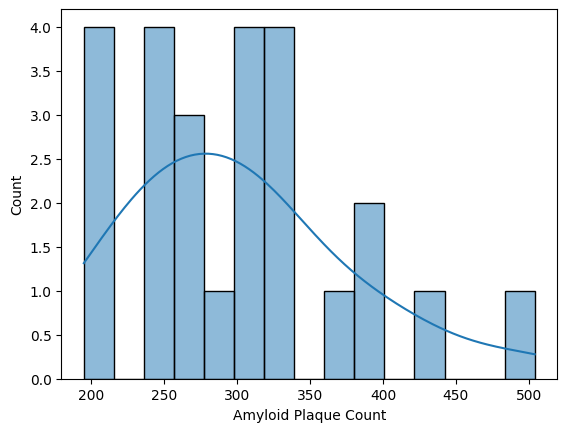

In [86]:
sns.histplot(data=sbc_df, x='Amyloid Plaque Count', bins=15, kde=True)

<Axes: xlabel='Total Amyloid IID', ylabel='Count'>

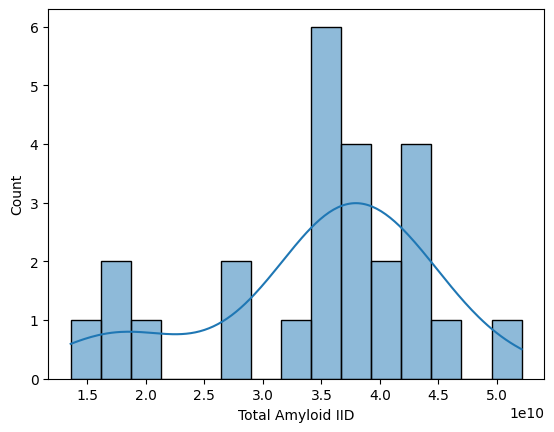

In [87]:
sns.histplot(data=sbc_df, x='Total Amyloid IID', bins=15, kde=True)

<Axes: xlabel='Microglia Count', ylabel='Count'>

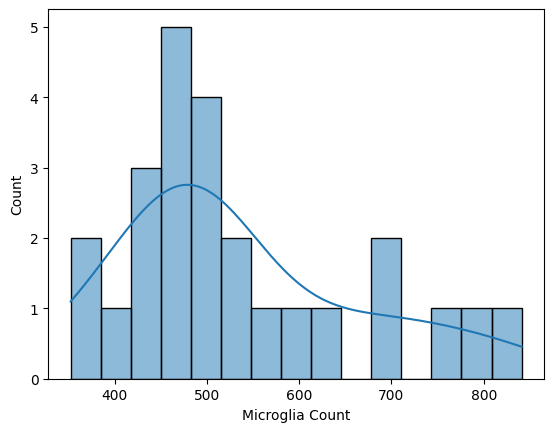

In [88]:
sns.histplot(data=sbc_df, x='Microglia Count', bins=15, kde=True)

<Axes: xlabel='Total Microglia IID', ylabel='Count'>

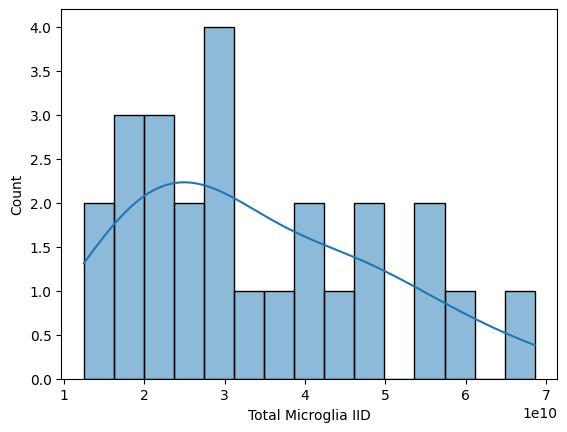

In [89]:
sns.histplot(data=sbc_df, x='Total Microglia IID', bins=15, kde=True)

<Axes: xlabel='LD Count', ylabel='Count'>

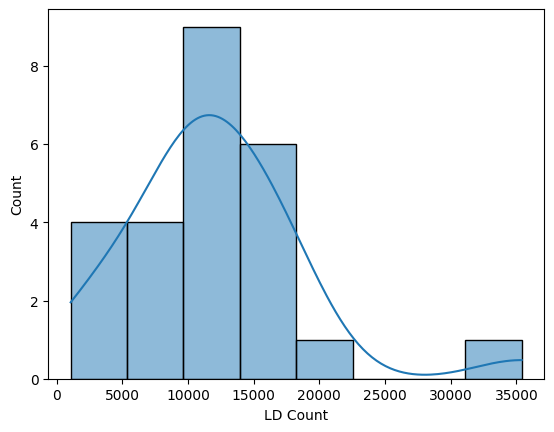

In [99]:
sns.histplot(x=sbc_df['LD Count'], kde=True)

<Axes: xlabel='BODIPY IID', ylabel='Count'>

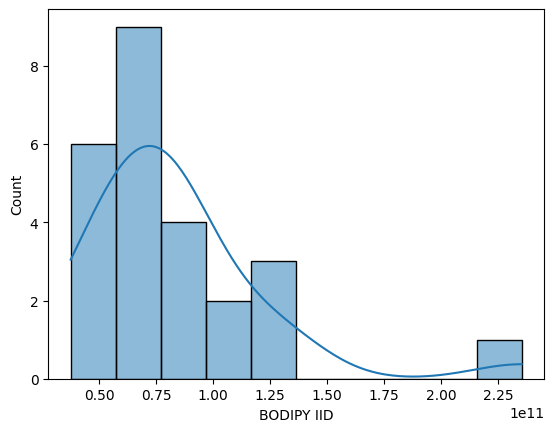

In [100]:
sns.histplot(x=sbc_df['BODIPY IID'], kde=True)

PearsonRResult(statistic=0.9108690871251811, pvalue=2.587505740961715e-10)

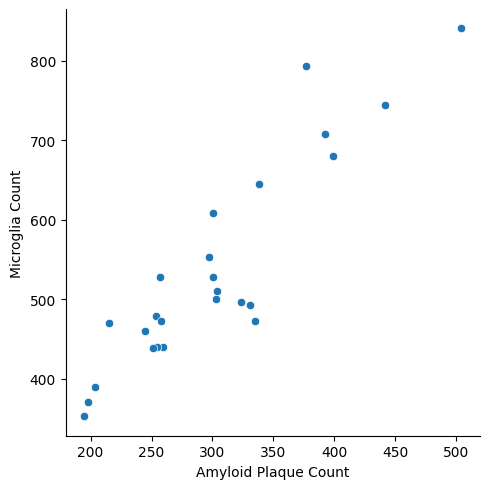

In [90]:
sns.relplot(x=sbc_df['Amyloid Plaque Count'], y=sbc_df['Microglia Count'])
scipy.stats.pearsonr(x=sbc_df['Amyloid Plaque Count'], y=sbc_df['Microglia Count'])

PearsonRResult(statistic=0.2507582370995168, pvalue=0.22664915583331682)

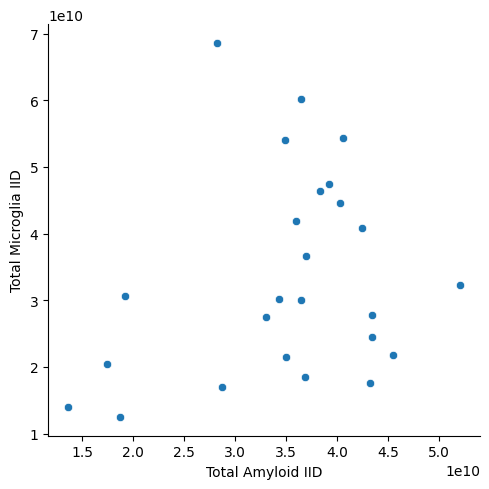

In [93]:
sns.relplot(x=sbc_df['Total Amyloid IID'], y=sbc_df['Total Microglia IID'])
scipy.stats.pearsonr(x=sbc_df['Total Amyloid IID'], y=sbc_df['Total Microglia IID'])

PearsonRResult(statistic=0.3837178685839662, pvalue=0.05828029495318863)

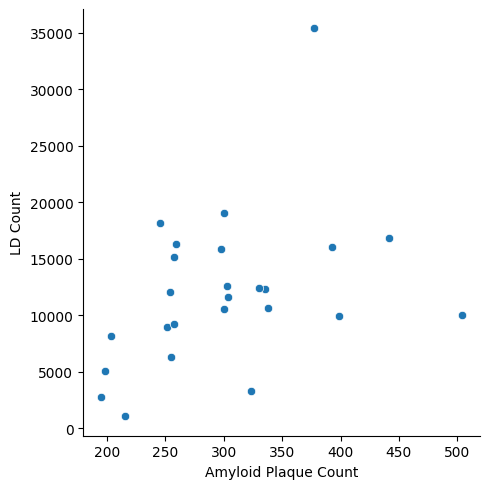

In [97]:
sns.relplot(x=sbc_df['Amyloid Plaque Count'], y=sbc_df['LD Count'])
scipy.stats.pearsonr(x=sbc_df['Amyloid Plaque Count'], y=sbc_df['LD Count'])

PearsonRResult(statistic=0.5193361589988804, pvalue=0.007804011087390715)

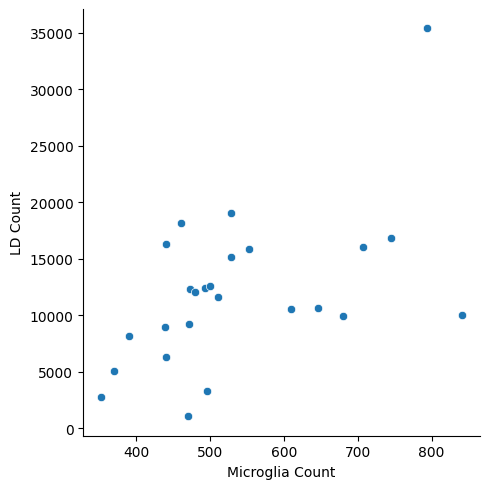

In [98]:
sns.relplot(x=sbc_df['Microglia Count'], y=sbc_df['LD Count'])
scipy.stats.pearsonr(x=sbc_df['Microglia Count'], y=sbc_df['LD Count'])